### Dependences

In [2]:
import sys
sys.path.append("../")

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from IPython.display import clear_output

from lib.models.Deeper_SRCNN import DeeperSRCNN
import lib.utils as utils

### Loading experiment data

In [3]:
#set experiment ID
EXP_ID = "DeeperSRCNN"
utils.create_experiment_folders(EXP_ID)
utils.load_experiment_data()


### Model instantiation

In [5]:
model = DeeperSRCNN()
model.build((None,120,120,3))
print(model.summary())


Model: "deeper_srcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  2432      
_________________________________________________________________
sequential (Sequential)      multiple                  76896     
_________________________________________________________________
sequential_1 (Sequential)    multiple                  76896     
_________________________________________________________________
sequential_2 (Sequential)    multiple                  76896     
_________________________________________________________________
sequential_3 (Sequential)    multiple                  76896     
_________________________________________________________________
sequential_4 (Sequential)    multiple                  76896     
_________________________________________________________________
sequential_5 (Sequential)    multiple                 

### Loading Dataset

2424it [00:53, 45.50it/s]


Loaded 2424 samples


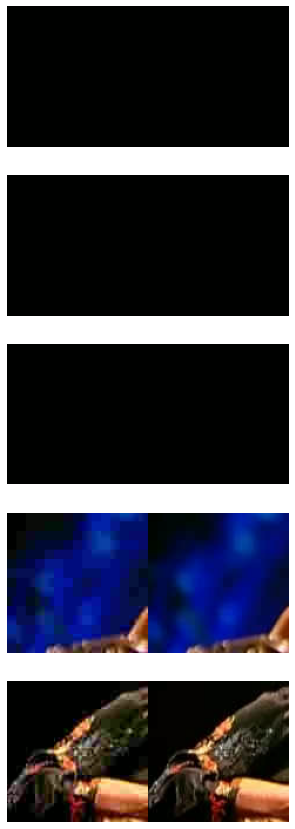

In [6]:
#Loading the training dataset
train_x, train_y = utils.load_dataset("../../dataset/dataset_video_frames/train",  limit=None, inRoot=True) 

print("Loaded",train_x.shape[0], "samples")

#check the five firts samples   
utils.show_samples(train_x, train_y, begin=0, end=5)

60it [00:01, 38.47it/s]


Loaded 60 samples


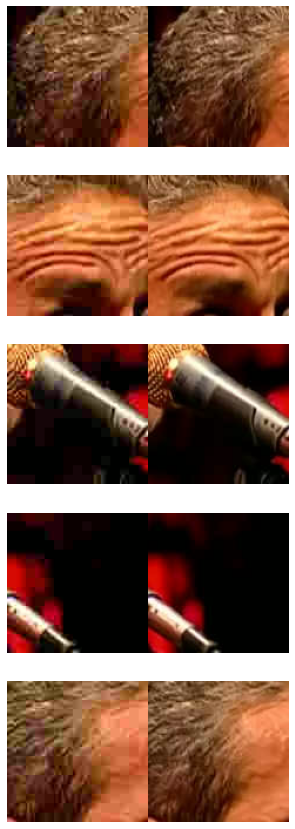

In [7]:
#Loading the training dataset
valid_x, valid_y = utils.load_dataset("../../dataset/dataset_video_frames/valid",  limit=None, inRoot=True)

print("Loaded",valid_x.shape[0], "samples")

#check the five firts samples   
utils.show_samples(valid_x, valid_y, begin=0, end=5)

### Dataset shift and normalization

In [8]:
SHIFT_VALUE_X, SHIFT_VALUE_Y, SCALE_VALUE_X, SCALE_VALUE_Y = utils.get_shift_scale_maxmin(train_x, train_y, valid_x, valid_y)

train_x = utils.shift_and_normalize(train_x, SHIFT_VALUE_X, SCALE_VALUE_X)
train_y = utils.shift_and_normalize(train_y, SHIFT_VALUE_Y, SCALE_VALUE_Y)

valid_x = utils.shift_and_normalize(valid_x, SHIFT_VALUE_X, SCALE_VALUE_X)
valid_y = utils.shift_and_normalize(valid_y, SHIFT_VALUE_Y, SCALE_VALUE_Y)

### Batches split

In [9]:
train_batches = utils.random_mini_batches(train_x, train_y, 8, seed=0)
valid_batches = utils.random_mini_batches(valid_x, valid_y, 8, seed=0)
print("train_batches:", len(train_batches), "valid_batches:", len(valid_batches))

train_batches: 303 valid_batches: 8


### Metrics

In [10]:
#default tf.keras metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_mse = tf.keras.metrics.MeanSquaredError(name='train_mse')

#psnr, ssim and nrmse
valid_custom_metrics = utils.CustomMetric()

### Set Loss and load model weights

In [11]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#get last saved epoch index and best result in validation step
CURRENT_EPOCH, BEST_VALIDATION = utils.get_model_last_data()
if CURRENT_EPOCH > 0:
    print("Loading last model state in epoch", CURRENT_EPOCH)
    model.load_weights(utils.get_exp_folder_last_epoch())
    print("Best validation result was SSIM=", BEST_VALIDATION)

### Training

VALIDATION EPOCH 800
JPEG Q10 - JPEG Q50 - PREDICT


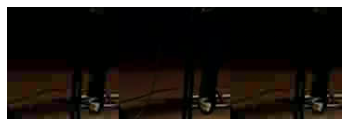

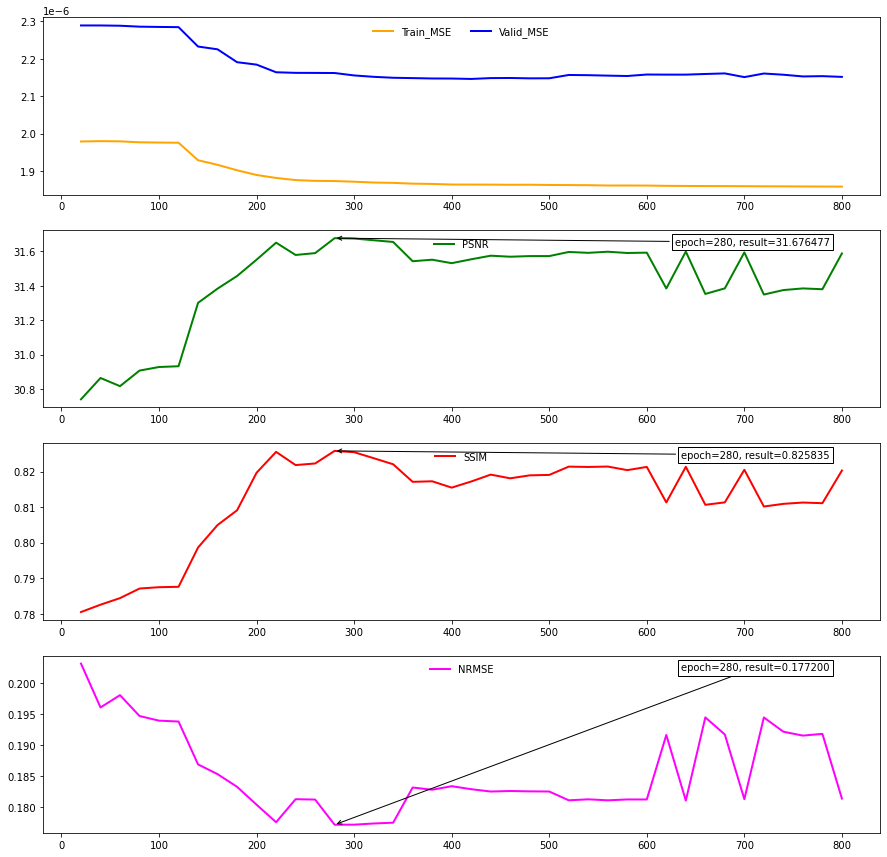

In [12]:
@tf.function
def train_step(image_x, image_y):
    with tf.GradientTape() as tape:
        predictions = model(image_x)
        loss = loss_object(image_y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)

MAX_EPOCHS = 801
EVAL_STEP = 20

for epoch in range(CURRENT_EPOCH, MAX_EPOCHS):
    
    #TRAINING
    print("TRAINING EPOCH", epoch)
   
    for batch in train_batches:
        (batch_x, batch_y) = batch
        train_step(batch_x, batch_y)
    
    #VALIDATION
    if epoch%EVAL_STEP == 0 and epoch > 0:
        #tf.keras.backend.set_learning_phase(0)
        clear_output()
        
        print("VALIDATION EPOCH", epoch)
        #saving last epoch model
        model.save_weights(utils.get_exp_folder_last_epoch(), save_format='tf')
        for index, batch in enumerate(valid_batches):
            (batch_x, batch_y) = batch
            predictions = model(batch_x)
            valid_mse(batch_y, predictions)
            
            # convert back to original pattern
            batch_x = utils.inv_shift_and_normalize(batch_x.copy(), SHIFT_VALUE_X, SCALE_VALUE_X)
            batch_y = utils.inv_shift_and_normalize(batch_y.copy(), SHIFT_VALUE_Y, SCALE_VALUE_Y)
            predictions = utils.inv_shift_and_normalize(predictions.numpy(), SHIFT_VALUE_Y, SCALE_VALUE_Y)
            
            #convert from frequency to pixel-rgb domain
            batch_x, batch_y, predictions = utils.convert_batch_dct2rgb(batch_x, batch_y, predictions)
            
            #feed the metric evaluator
            valid_custom_metrics.feed(batch_y, predictions)
            
            #just show the first example of batch-0
            if index == 0:
                print("JPEG Q10 - JPEG Q50 - PREDICT")
                utils.preview_sample(batch_x[0], batch_y[0], predictions[0])
        
        #get metric results
        psnr, ssim, nrmse = valid_custom_metrics.result()
        valid_mse_result = valid_mse.result().numpy()
        
        utils.update_chart_data(epoch=epoch, train_mse=train_loss.result().numpy(), 
                                valid_mse=valid_mse_result, psnr=psnr, ssim=ssim, nrmse=nrmse)
        utils.draw_chart()
        
        #saving best validation model
        if ssim > BEST_VALIDATION:
            BEST_VALIDATION = ssim
            model.save_weights(utils.get_exp_folder_best_valid(), save_format='tf')
        
    train_loss.reset_states()
    valid_mse.reset_states()
    valid_custom_metrics.reset_states()


### Usage

JPEG Q10 - JPEG Q50 - PREDICT


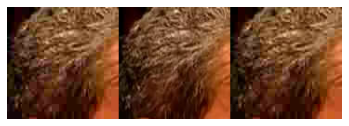

JPEG Q10 - JPEG Q50 - PREDICT


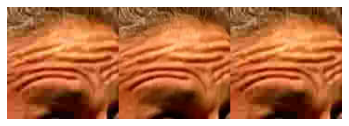

JPEG Q10 - JPEG Q50 - PREDICT


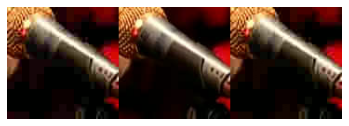

JPEG Q10 - JPEG Q50 - PREDICT


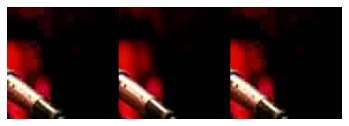

JPEG Q10 - JPEG Q50 - PREDICT


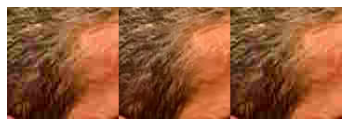

JPEG Q10 - JPEG Q50 - PREDICT


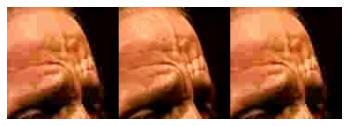

JPEG Q10 - JPEG Q50 - PREDICT


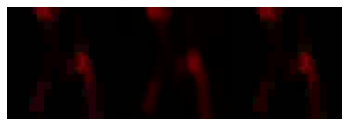

JPEG Q10 - JPEG Q50 - PREDICT


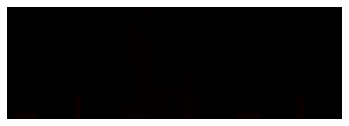

JPEG Q10 - JPEG Q50 - PREDICT


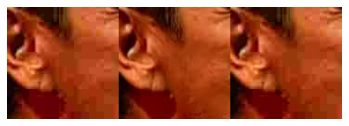

JPEG Q10 - JPEG Q50 - PREDICT


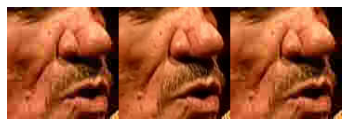

JPEG Q10 - JPEG Q50 - PREDICT


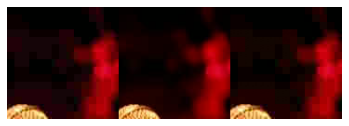

JPEG Q10 - JPEG Q50 - PREDICT


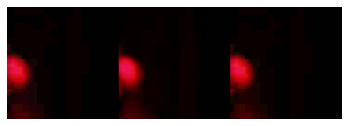

JPEG Q10 - JPEG Q50 - PREDICT


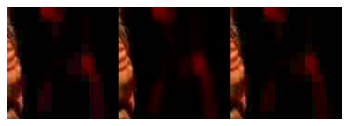

JPEG Q10 - JPEG Q50 - PREDICT


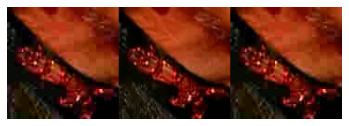

JPEG Q10 - JPEG Q50 - PREDICT


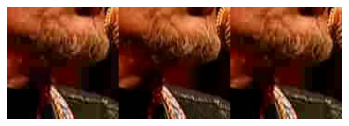

JPEG Q10 - JPEG Q50 - PREDICT


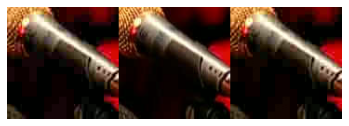

JPEG Q10 - JPEG Q50 - PREDICT


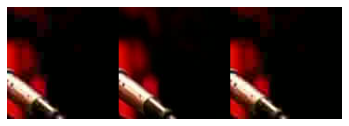

JPEG Q10 - JPEG Q50 - PREDICT


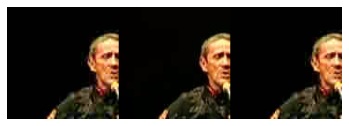

JPEG Q10 - JPEG Q50 - PREDICT


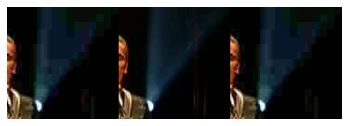

JPEG Q10 - JPEG Q50 - PREDICT


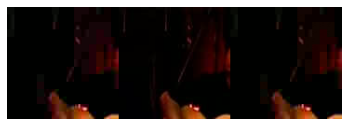

JPEG Q10 - JPEG Q50 - PREDICT


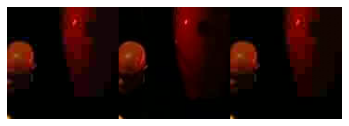

JPEG Q10 - JPEG Q50 - PREDICT


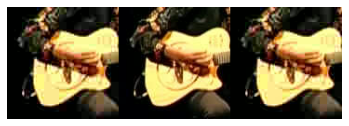

JPEG Q10 - JPEG Q50 - PREDICT


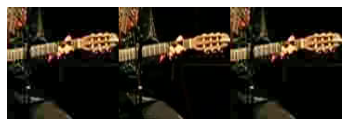

JPEG Q10 - JPEG Q50 - PREDICT


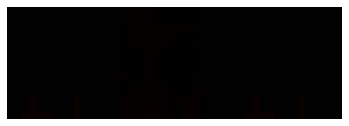

JPEG Q10 - JPEG Q50 - PREDICT


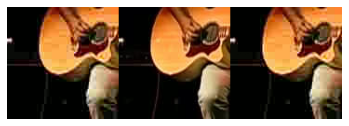

JPEG Q10 - JPEG Q50 - PREDICT


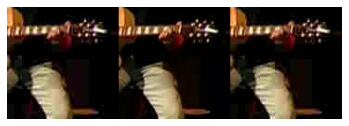

JPEG Q10 - JPEG Q50 - PREDICT


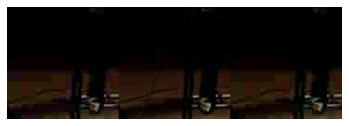

JPEG Q10 - JPEG Q50 - PREDICT


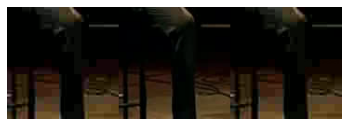

JPEG Q10 - JPEG Q50 - PREDICT


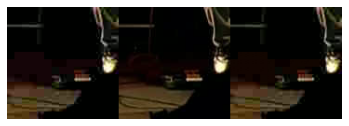

JPEG Q10 - JPEG Q50 - PREDICT


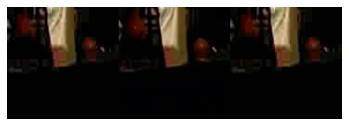

JPEG Q10 - JPEG Q50 - PREDICT


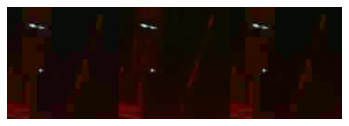

JPEG Q10 - JPEG Q50 - PREDICT


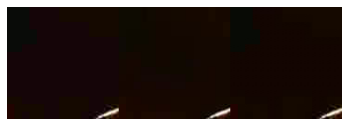

JPEG Q10 - JPEG Q50 - PREDICT


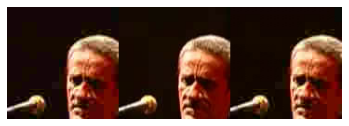

JPEG Q10 - JPEG Q50 - PREDICT


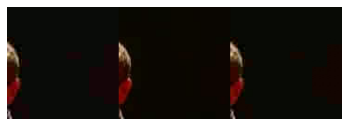

JPEG Q10 - JPEG Q50 - PREDICT


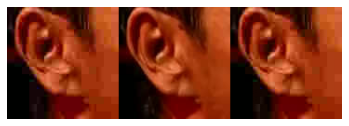

JPEG Q10 - JPEG Q50 - PREDICT


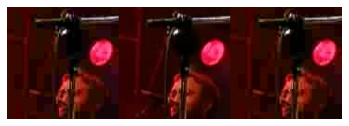

JPEG Q10 - JPEG Q50 - PREDICT


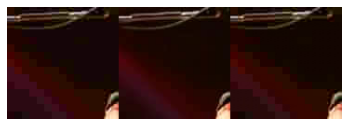

JPEG Q10 - JPEG Q50 - PREDICT


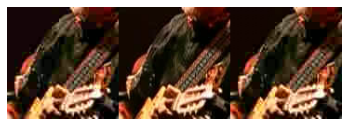

JPEG Q10 - JPEG Q50 - PREDICT


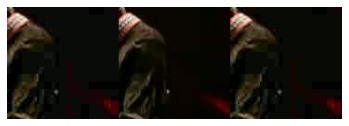

JPEG Q10 - JPEG Q50 - PREDICT


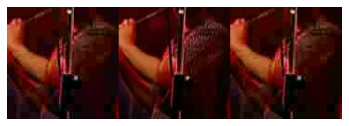

JPEG Q10 - JPEG Q50 - PREDICT


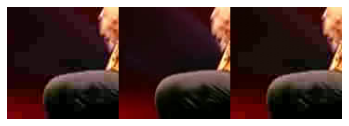

JPEG Q10 - JPEG Q50 - PREDICT


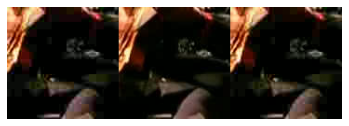

JPEG Q10 - JPEG Q50 - PREDICT


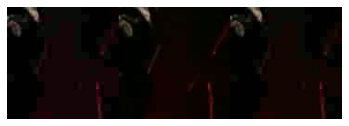

JPEG Q10 - JPEG Q50 - PREDICT


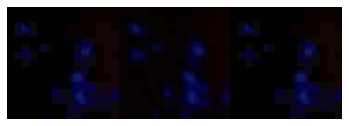

JPEG Q10 - JPEG Q50 - PREDICT


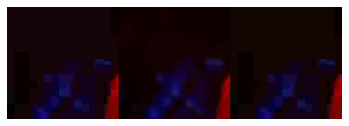

JPEG Q10 - JPEG Q50 - PREDICT


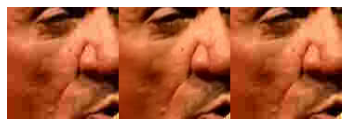

JPEG Q10 - JPEG Q50 - PREDICT


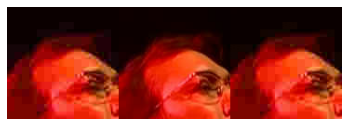

JPEG Q10 - JPEG Q50 - PREDICT


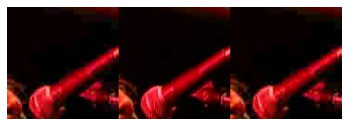

JPEG Q10 - JPEG Q50 - PREDICT


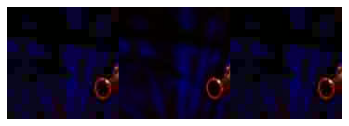

JPEG Q10 - JPEG Q50 - PREDICT


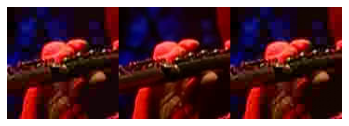

JPEG Q10 - JPEG Q50 - PREDICT


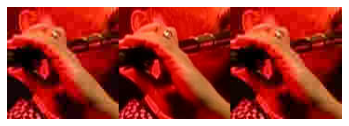

JPEG Q10 - JPEG Q50 - PREDICT


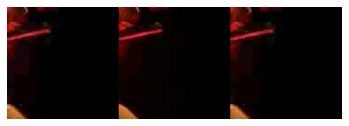

JPEG Q10 - JPEG Q50 - PREDICT


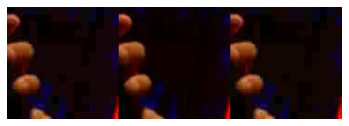

JPEG Q10 - JPEG Q50 - PREDICT


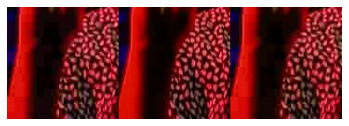

JPEG Q10 - JPEG Q50 - PREDICT


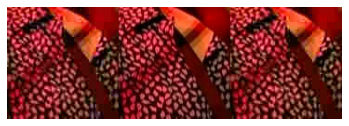

JPEG Q10 - JPEG Q50 - PREDICT


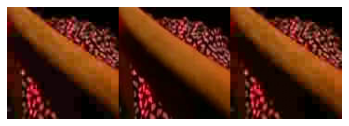

JPEG Q10 - JPEG Q50 - PREDICT


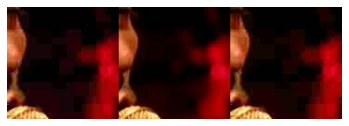

JPEG Q10 - JPEG Q50 - PREDICT


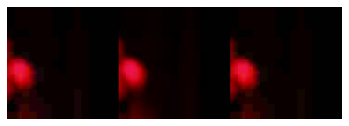

JPEG Q10 - JPEG Q50 - PREDICT


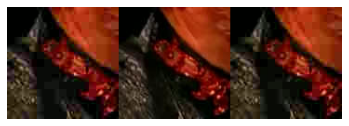

JPEG Q10 - JPEG Q50 - PREDICT


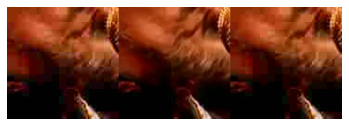

In [13]:
#load the model with best SSIM
model.load_weights(utils.get_exp_folder_best_valid())


for img_index in range(0, valid_x.shape[0]):
    img_x = valid_x[img_index:(img_index+1)]
    img_y = valid_y[img_index:(img_index+1)]
    prediction = model(img_x)

    img_x = utils.inv_shift_and_normalize(img_x.copy(), SHIFT_VALUE_X, SCALE_VALUE_X)
    img_y = utils.inv_shift_and_normalize(img_y.copy(), SHIFT_VALUE_Y, SCALE_VALUE_Y)
    prediction = utils.inv_shift_and_normalize(prediction.numpy(), SHIFT_VALUE_Y, SCALE_VALUE_Y)

    #convert from frequency to pixel-rgb domain
    img_x, img_y, prediction = utils.convert_batch_dct2rgb(img_x, img_y, prediction)
    print("JPEG Q10 - JPEG Q50 - PREDICT")
    utils.preview_sample(img_x[0], img_y[0], prediction[0])
    plt.pause(0.1)
